In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import shap
shap.initjs()

In [29]:
df = pd.read_csv("term-deposit-marketing-2020.csv")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [30]:
# Describe the numeric columns
df.describe()

,age,balance,day,duration,campaign
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,40.544600,1274.277550,16.017225,254.824300,2.882175
std,9.641776,2903.769716,8.278127,259.366498,3.239051
min,19.000000,-8019.000000,1.000000,0.000000,1.000000
25%,33.000000,54.000000,8.000000,100.000000,1.000000
50%,39.000000,407.000000,17.000000,175.000000,2.000000
75%,48.000000,1319.000000,21.000000,313.000000,3.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000


In [31]:
df.isnull().any().any()

False

In [32]:
df.y = df.y.eq('yes').mul(1)

In [33]:
numeric_cols = df.select_dtypes(include=np.number).columns
numeric_cols.drop('y')
bin_ranges = {
    'age': [20, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 100], # limit to ~5
    'balance': range(5,400,5),
    'day': range(0,32,1),
    'duration': [i for i in range(0, 1100, 100)],
    'campaign': [0,2,3,4,5,6,7,20]
} # leave age and duration as num

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


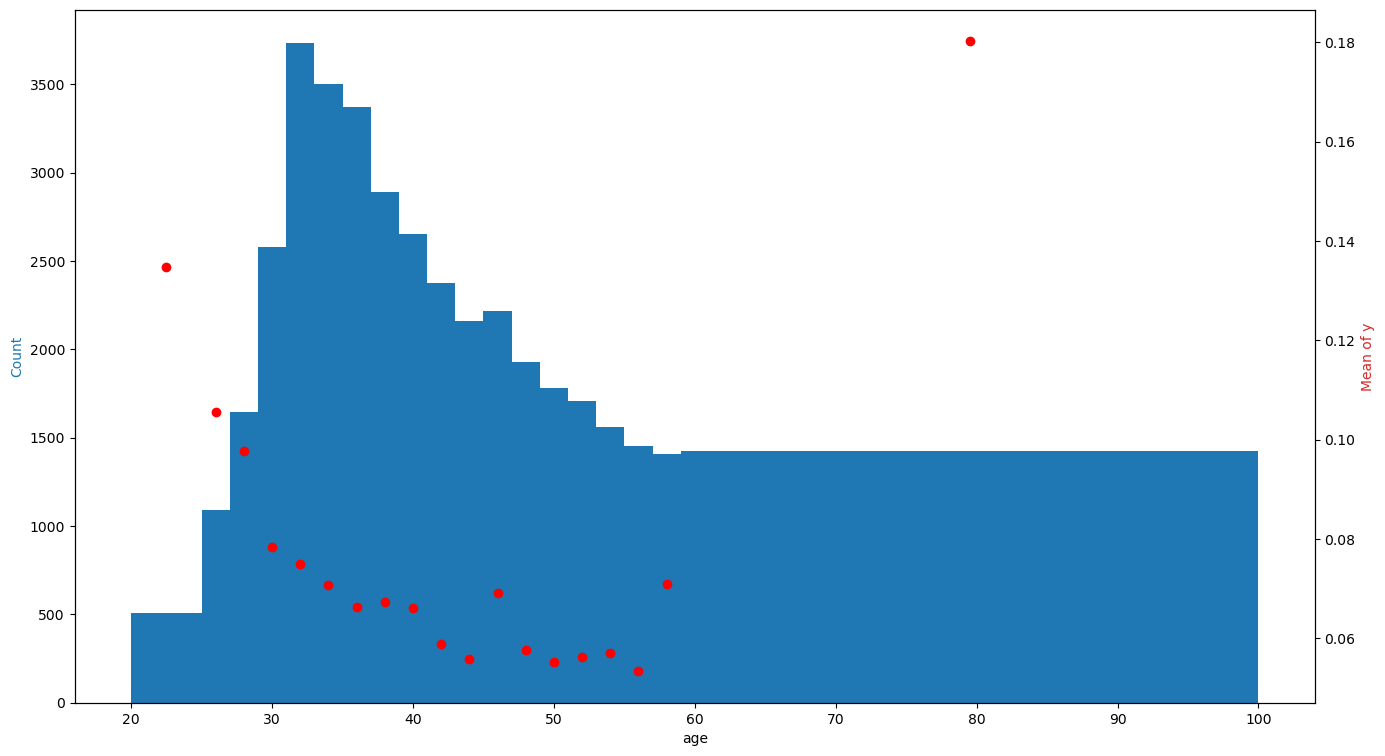

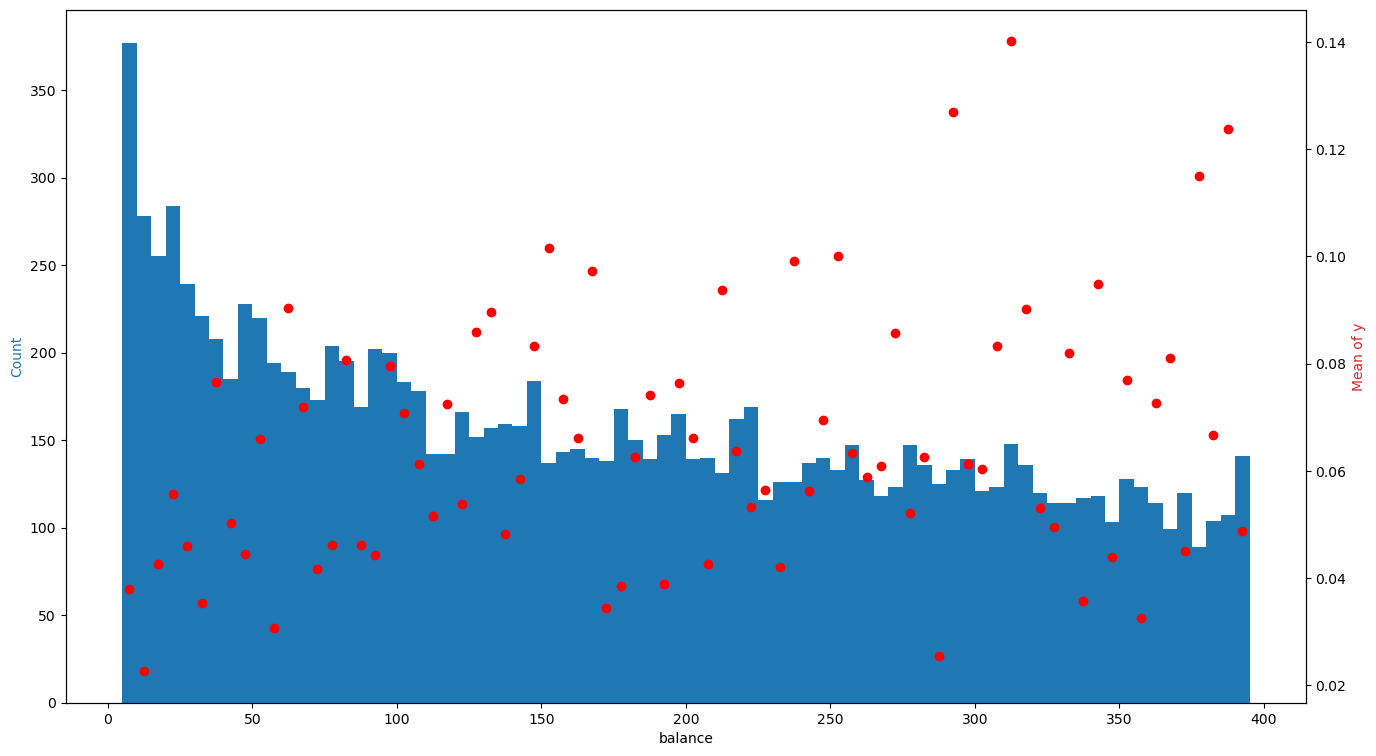

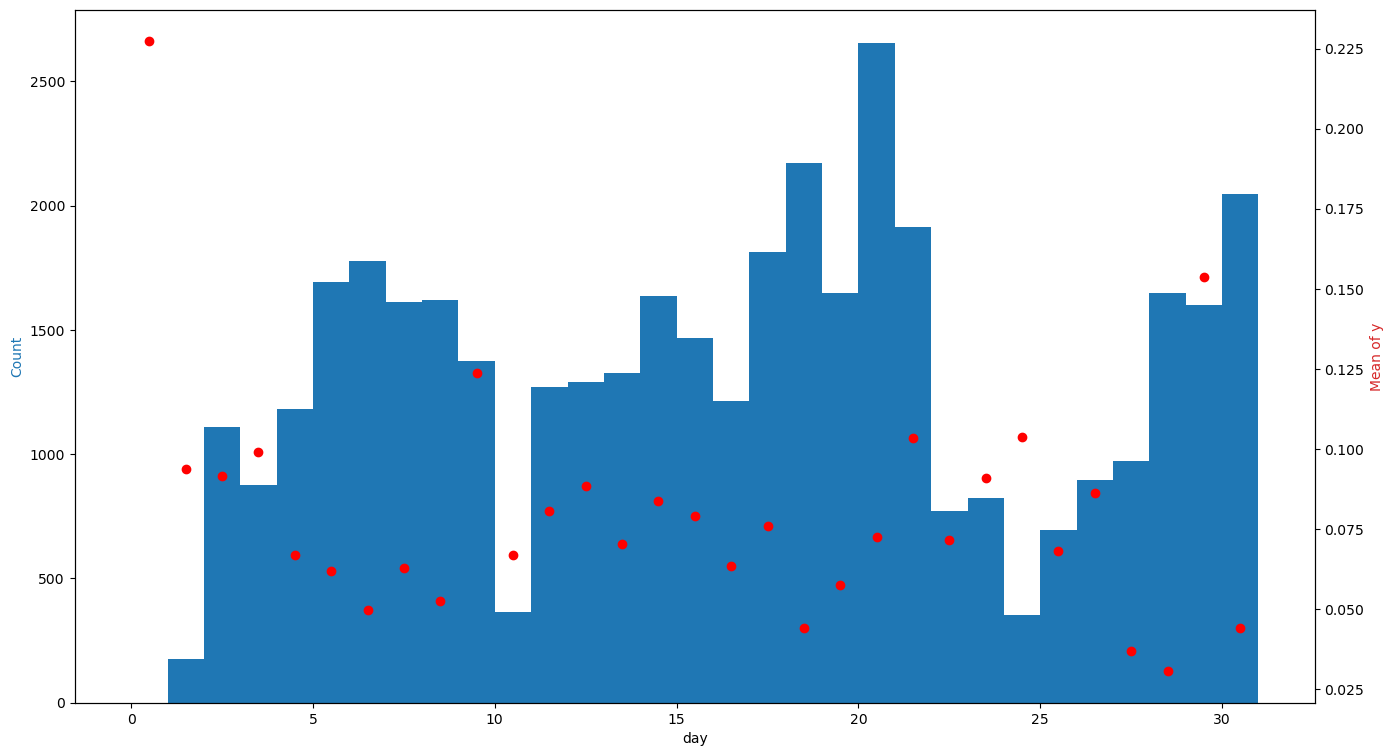

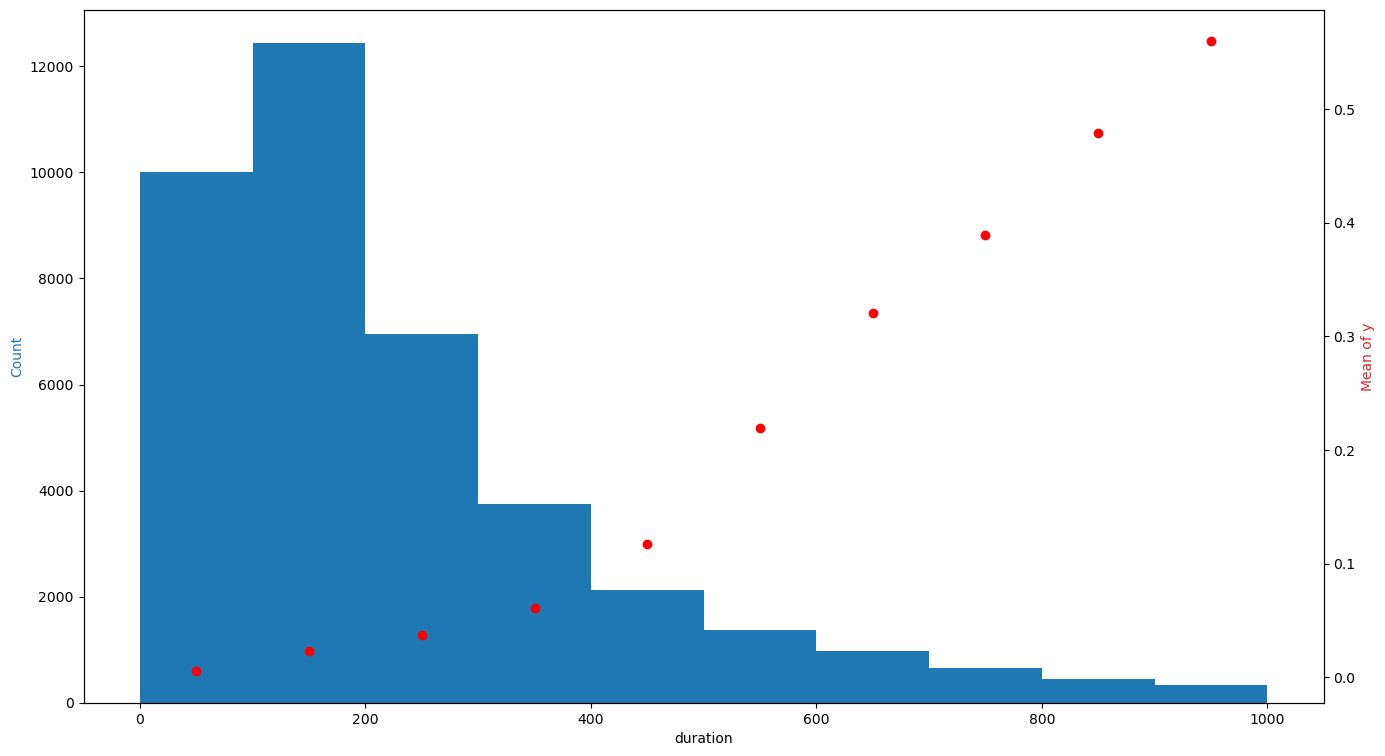

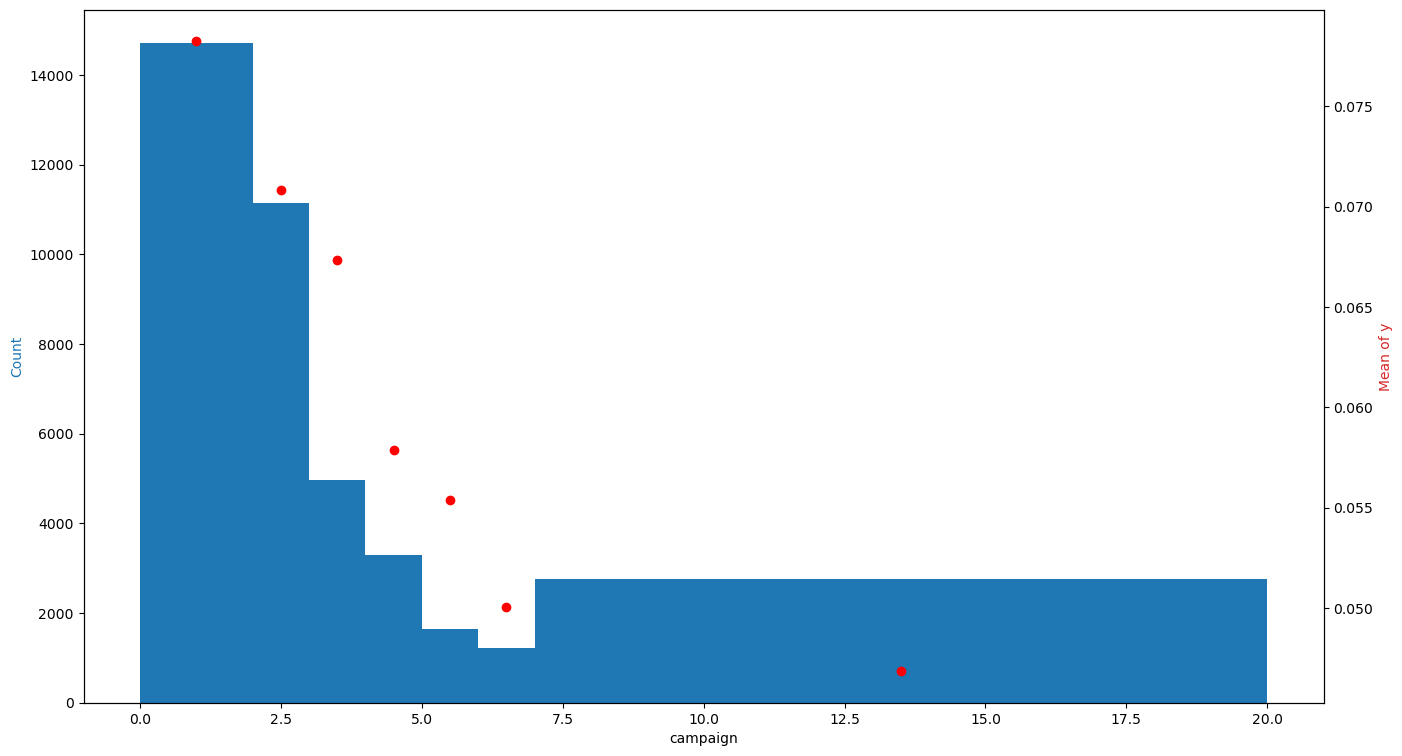

In [34]:

for col in bin_ranges:
    fig, ax = plt.subplots(figsize=(16,9))
    y_mean = df.groupby(pd.cut(df[col], bins=bin_ranges[col]))['y'].mean()
    xs = [i.mid for i in y_mean.index]
    color = 'tab:blue'
    ax.set_xlabel(col)
    ax.set_ylabel('Count', color=color)
    plt.hist(df[col], bins=bin_ranges[col])
    ax2 = ax.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Mean of y', color=color)
    ax2.scatter(xs, y_mean.values, color='red')
    # ax2.set_ylim([0,1])
    plt.show()

In [35]:
pd.cut(df.age, bins=[0, 10,20,30,40,50,60,70,80,90], labels=range(9), right=False)
df.campaign

0        1
1        1
2        1
3        1
4        1
        ..
39995    1
39996    3
39997    1
39998    1
39999    1
Name: campaign, Length: 40000, dtype: int64

In [86]:
X, y = df.drop(["y"], axis=1), df["y"]
X_pos = X.loc[y == 1]
X_neg = X.loc[y == 0]

In [37]:
X_pos.describe()

,age,balance,day,duration,campaign
count,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000
mean,39.844959,1588.495856,15.827003,682.958564,2.414365
std,11.001984,2924.894429,8.557604,431.287174,2.306015
min,19.000000,-3058.000000,1.000000,8.000000,1.000000
25%,31.000000,141.000000,8.000000,364.000000,1.000000
50%,37.000000,620.000000,16.000000,629.000000,2.000000
75%,47.000000,1820.500000,22.000000,913.000000,3.000000
max,95.000000,45248.000000,31.000000,3881.000000,32.000000


In [38]:
X_neg.describe()

,age,balance,day,duration,campaign
count,37104.000000,37104.000000,37104.000000,37104.000000,37104.000000
mean,40.599208,1249.752533,16.032072,221.408042,2.918688
std,9.525450,2900.722436,8.255850,206.360022,3.298031
min,19.000000,-8019.000000,1.000000,0.000000,1.000000
25%,33.000000,50.000000,8.000000,95.000000,1.000000
50%,39.000000,395.000000,17.000000,164.000000,2.000000
75%,48.000000,1286.000000,21.000000,280.000000,3.000000
max,94.000000,102127.000000,31.000000,4918.000000,63.000000


In [39]:
numeric_cols = df.select_dtypes(include=np.number).columns
df[numeric_cols].corr()

,age,balance,day,duration,campaign,y
age,1.000000,0.081517,-0.011689,-0.036270,0.016204,-0.020273
balance,0.081517,1.000000,0.011662,0.014072,-0.008137,0.030232
day,-0.011689,0.011662,1.000000,-0.032983,0.165429,-0.006420
duration,-0.036270,0.014072,-0.032983,1.000000,-0.088387,0.461169
campaign,0.016204,-0.008137,0.165429,-0.088387,1.000000,-0.040350
y,-0.020273,0.030232,-0.006420,0.461169,-0.040350,1.000000


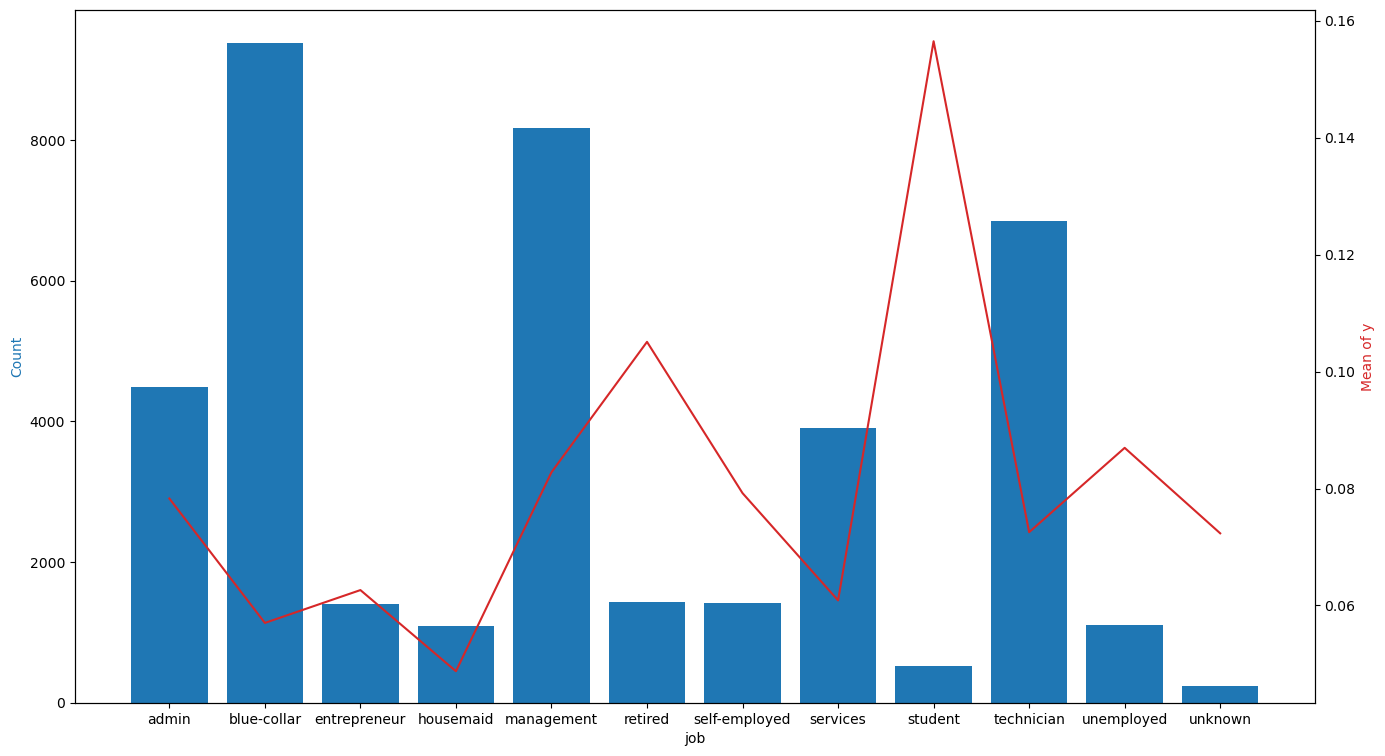

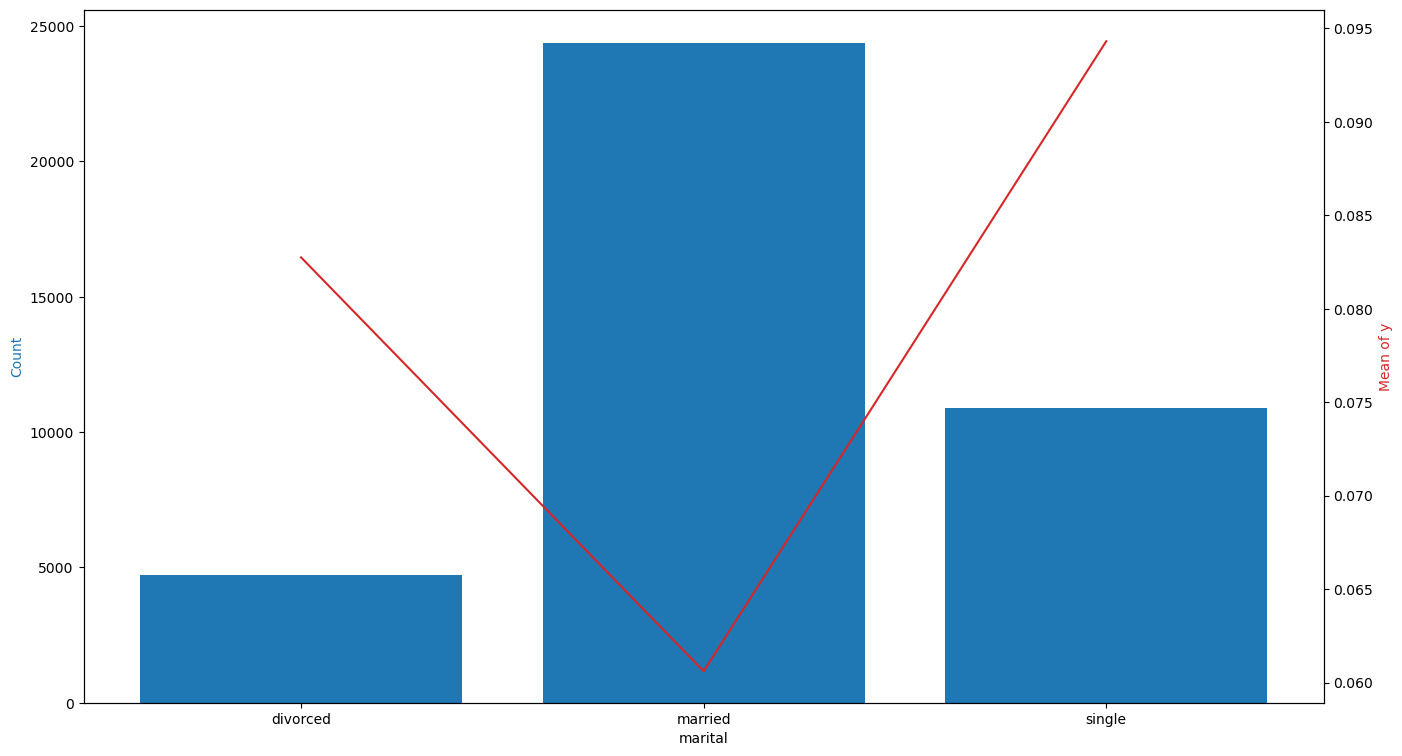

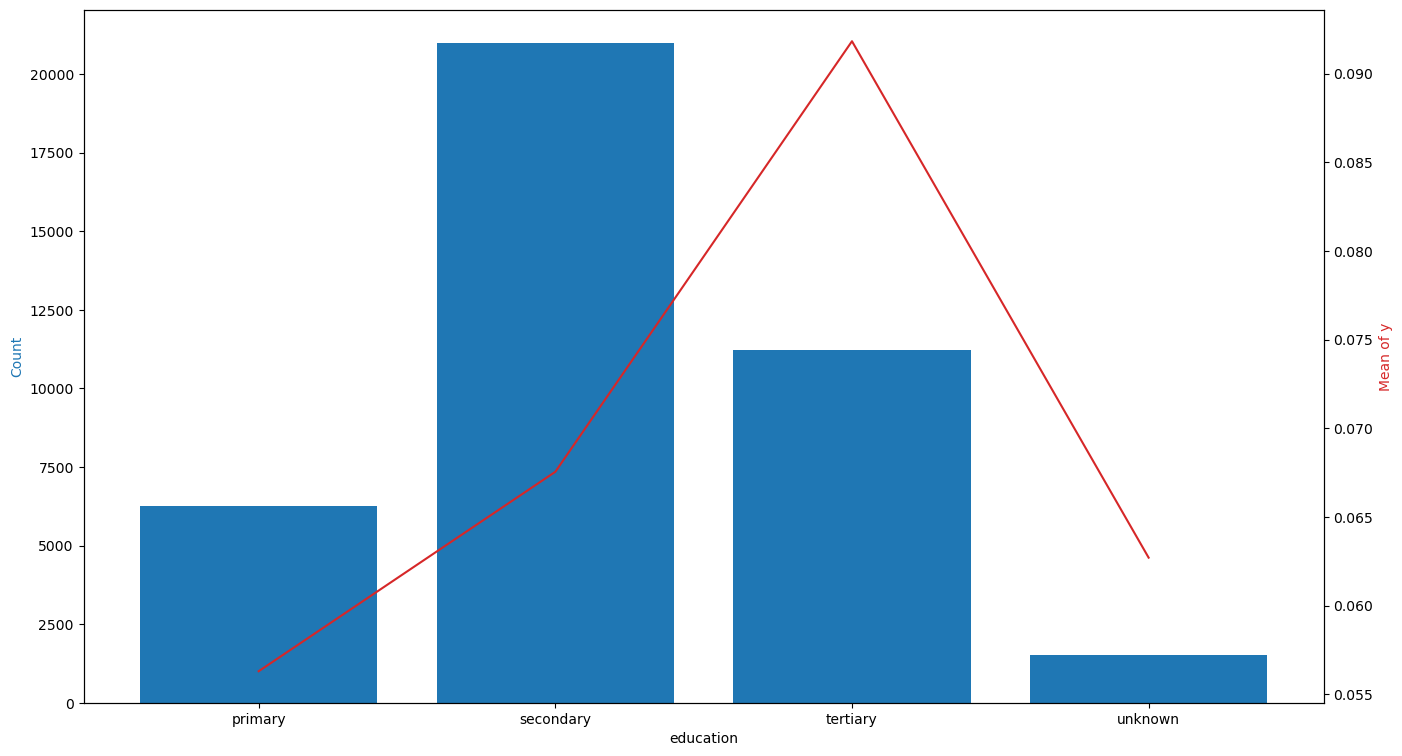

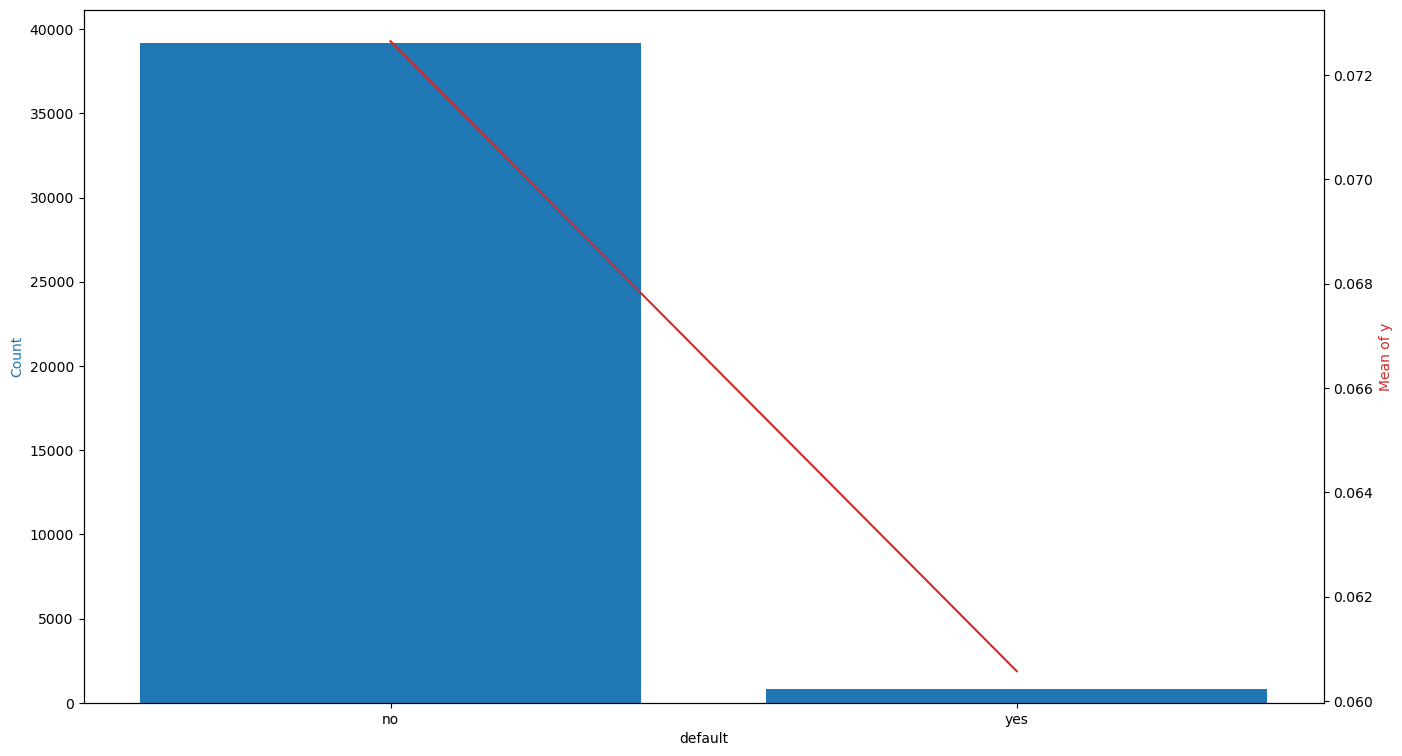

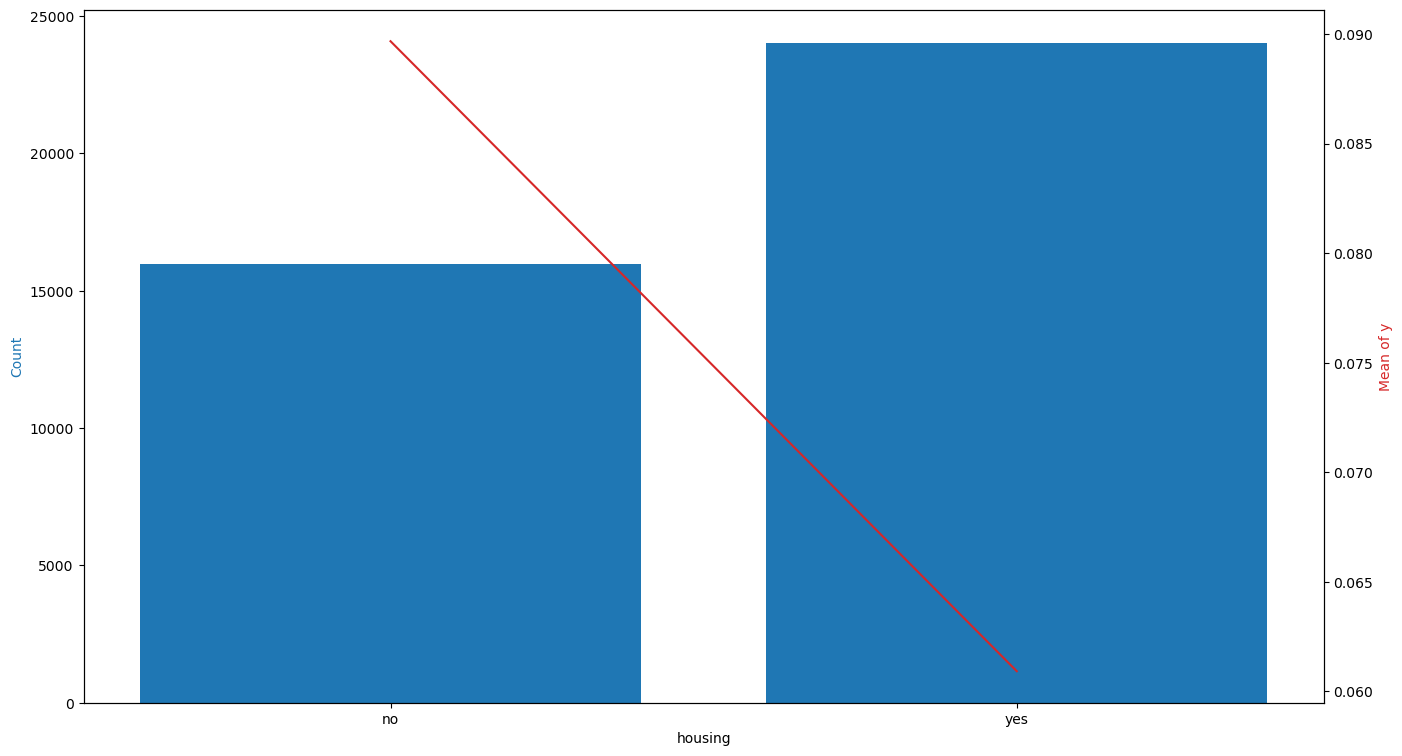

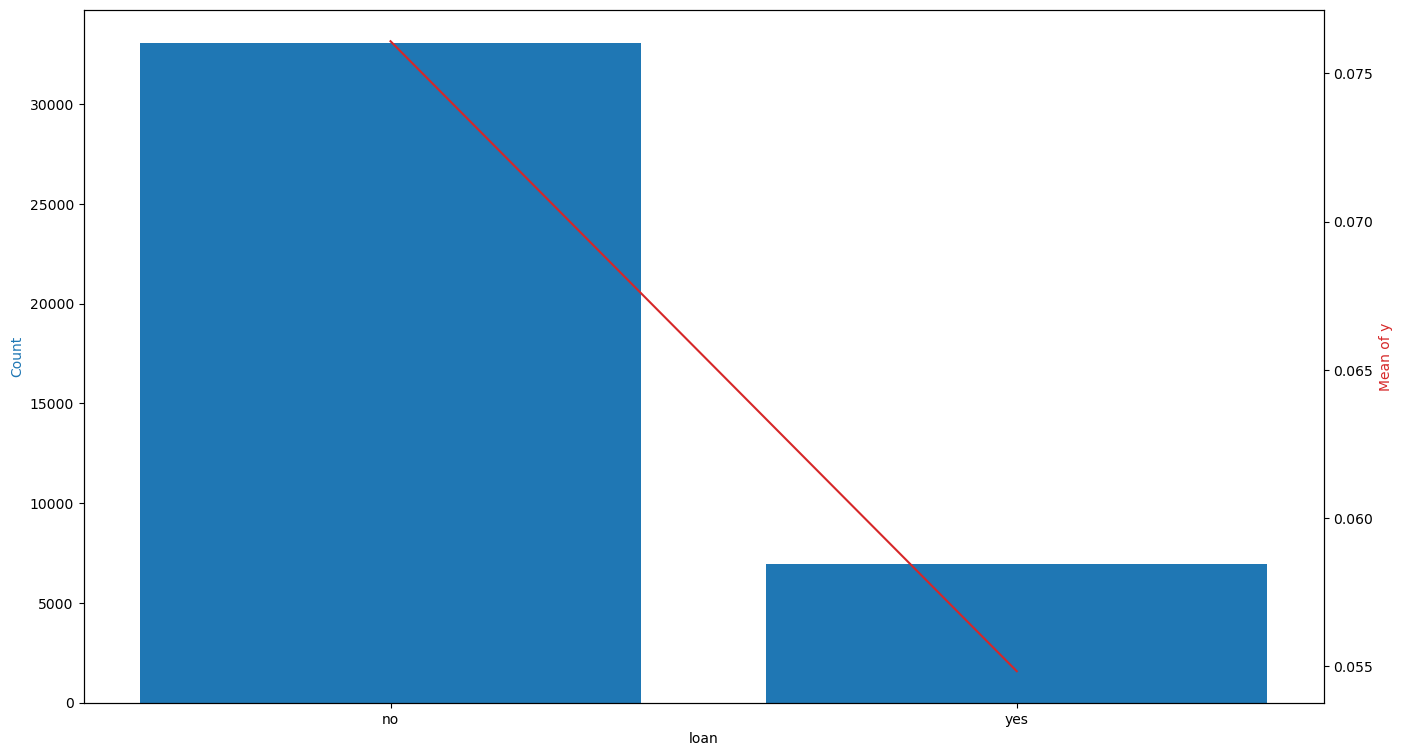

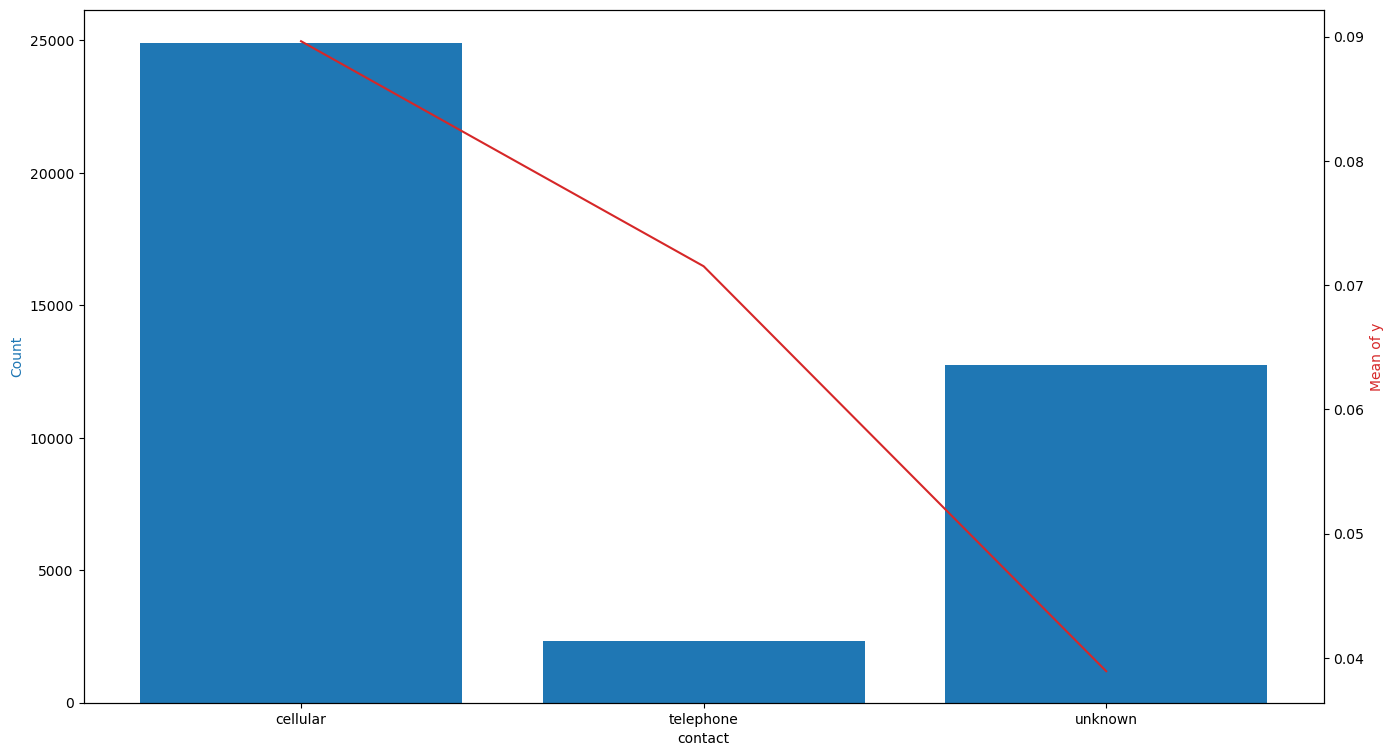

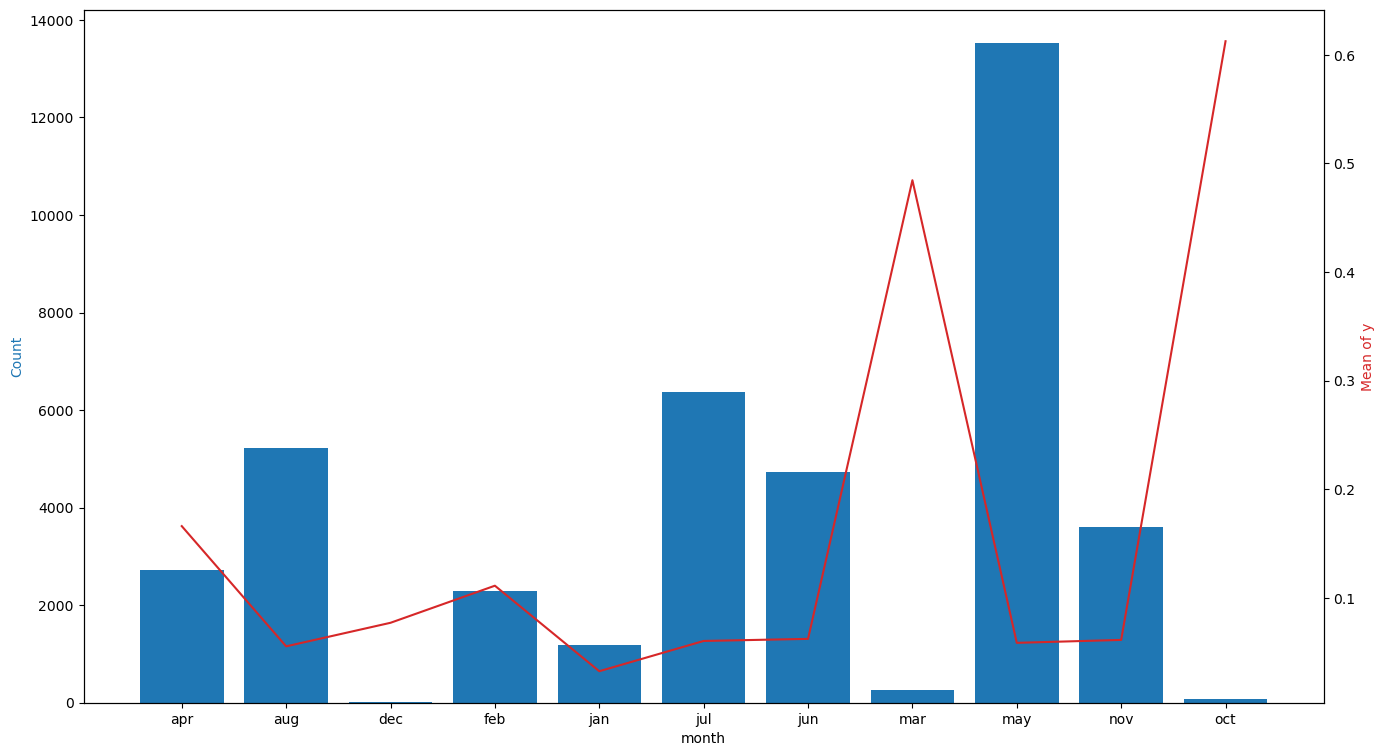

In [40]:
cat_cols = df.select_dtypes(include=np.object_).columns
for col in cat_cols:
    fig, ax = plt.subplots(figsize=(16,9))
    xi_avg = df.groupby(col).agg(mean_y=('y', 'mean'), count_x=(col, 'count'))
    color = 'tab:blue'
    ax.set_xlabel(col)
    ax.set_ylabel('Count', color=color)
    ax.bar(xi_avg.index, xi_avg.count_x, color=color)
    ax2 = ax.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Mean of y', color=color)
    ax2.plot(xi_avg.index, xi_avg.mean_y, color=color)
    # ax2.set_ylim([0,1])
    plt.show()


In [41]:
df = df.drop(['month', 'balance', 'day'], axis=1)
X, y = df.drop(["y"], axis=1), df["y"]
cat_cols = df.select_dtypes(include=np.object_).columns
numeric_cols = df.select_dtypes(include=np.number).columns

In [42]:
# Apply numerical transforms
for col in numeric_cols.drop('y'):
    X[col] = pd.cut(X[col], bins = bin_ranges[col], labels = range(len(bin_ranges[col]) - 1))

In [69]:
ohe = OneHotEncoder(drop = "if_binary", sparse_output=False)
X_t = ohe.fit_transform(X, y)

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X_t, y, random_state= 42)
model = XGBClassifier(n_estimators=5000, learning_rate = 0.01, scale_pos_weight=13, eval_metric="aucpr") # eval_metric aucpr
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [63]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.86      0.91      9283
           1       0.28      0.70      0.40       717

    accuracy                           0.85     10000
   macro avg       0.63      0.78      0.66     10000
weighted avg       0.92      0.85      0.88     10000



In [46]:
[[tp, fp], [fn, tn]] = confusion_matrix(y_test, y_pred)# add labels
print("        Actual    ")
print(f"    {tp}    {fp}")
print("Pred")
print(f"    {fn}    {tn}")

        Actual    
    8409    874
Pred
    327    390


In [47]:
X_test_agg = pd.DataFrame(ohe.inverse_transform(X_test), columns=X.columns)
X_test_agg.insert(0, "y_true", list(y_test))
X_test_agg.insert(0, "y_pred", y_pred)

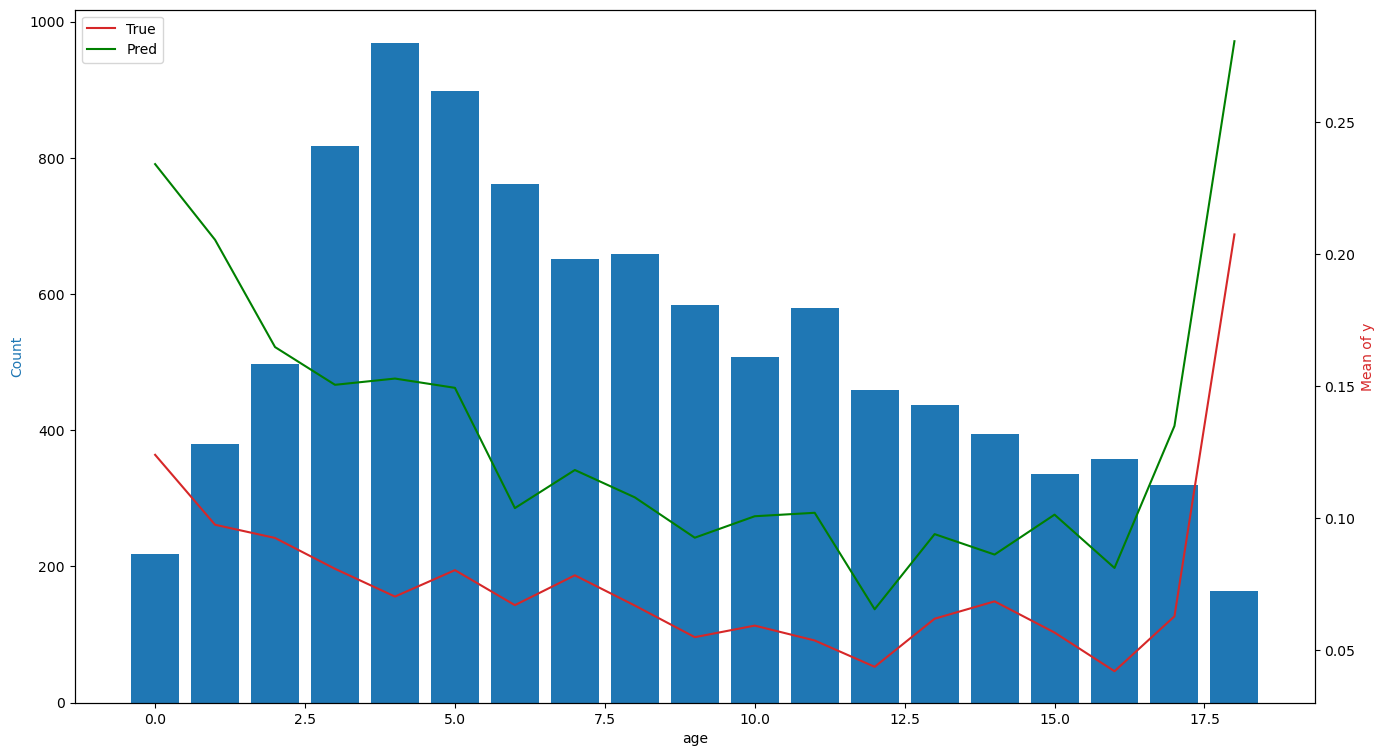

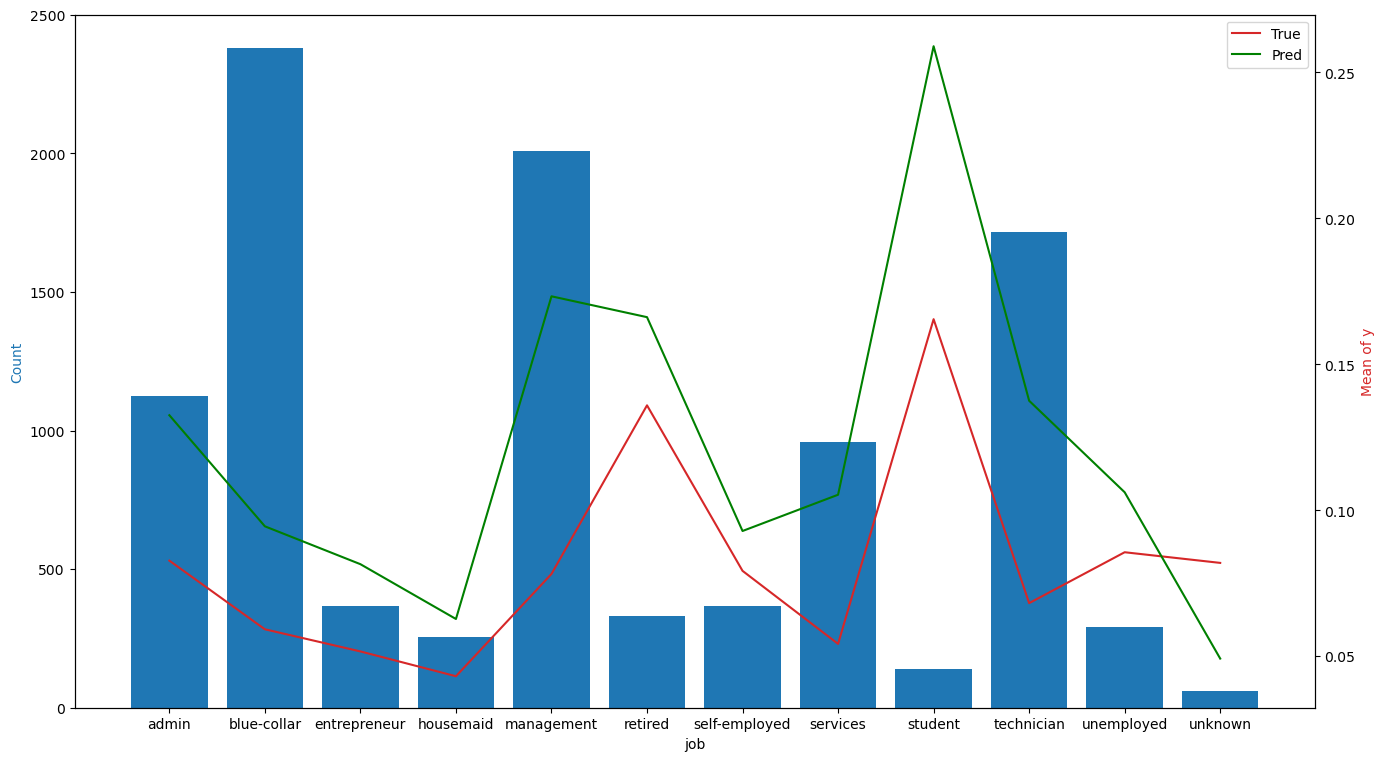

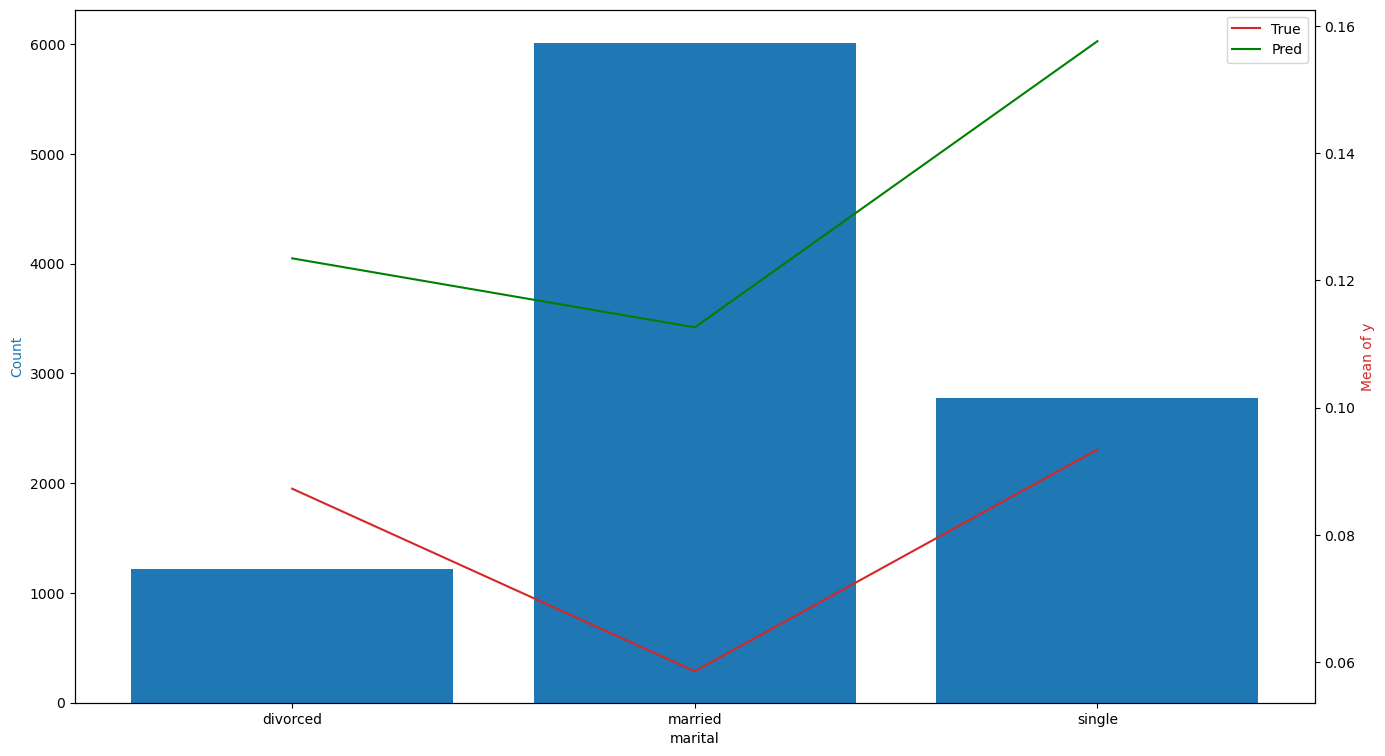

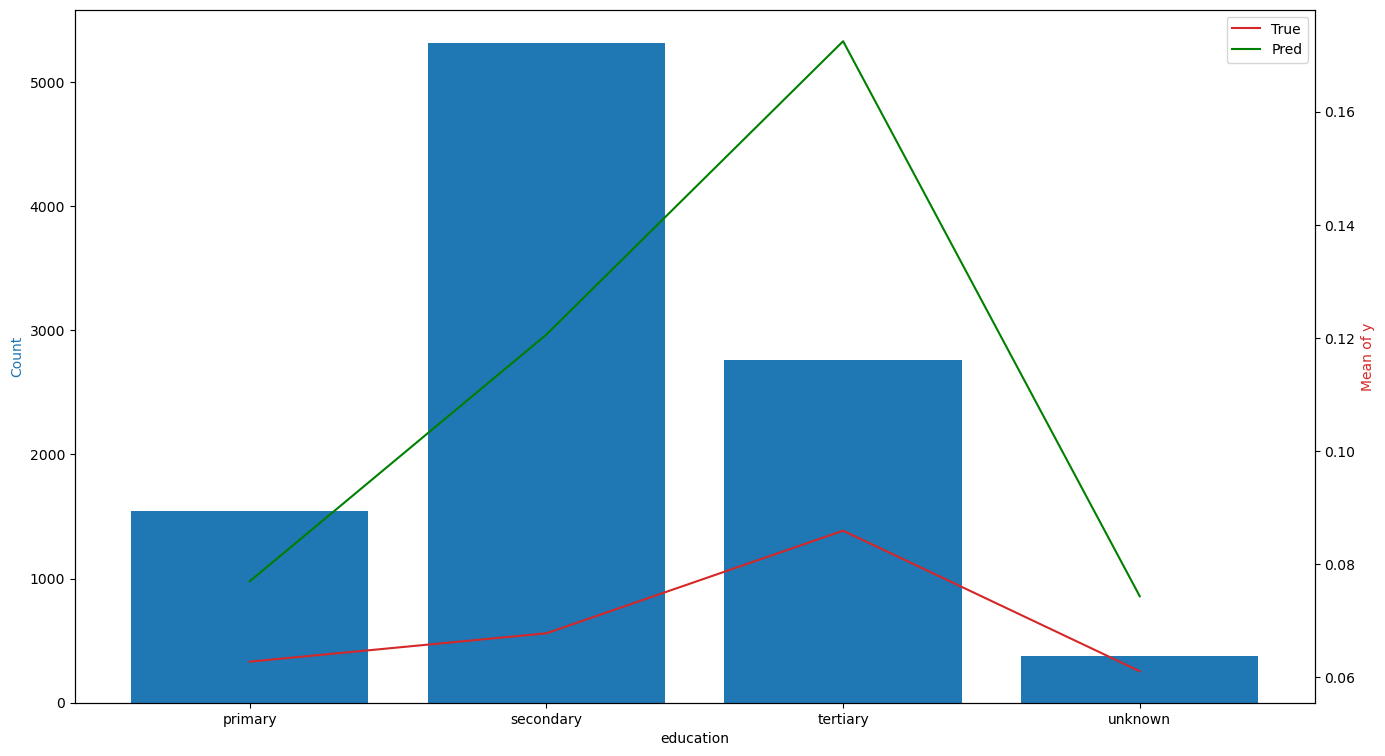

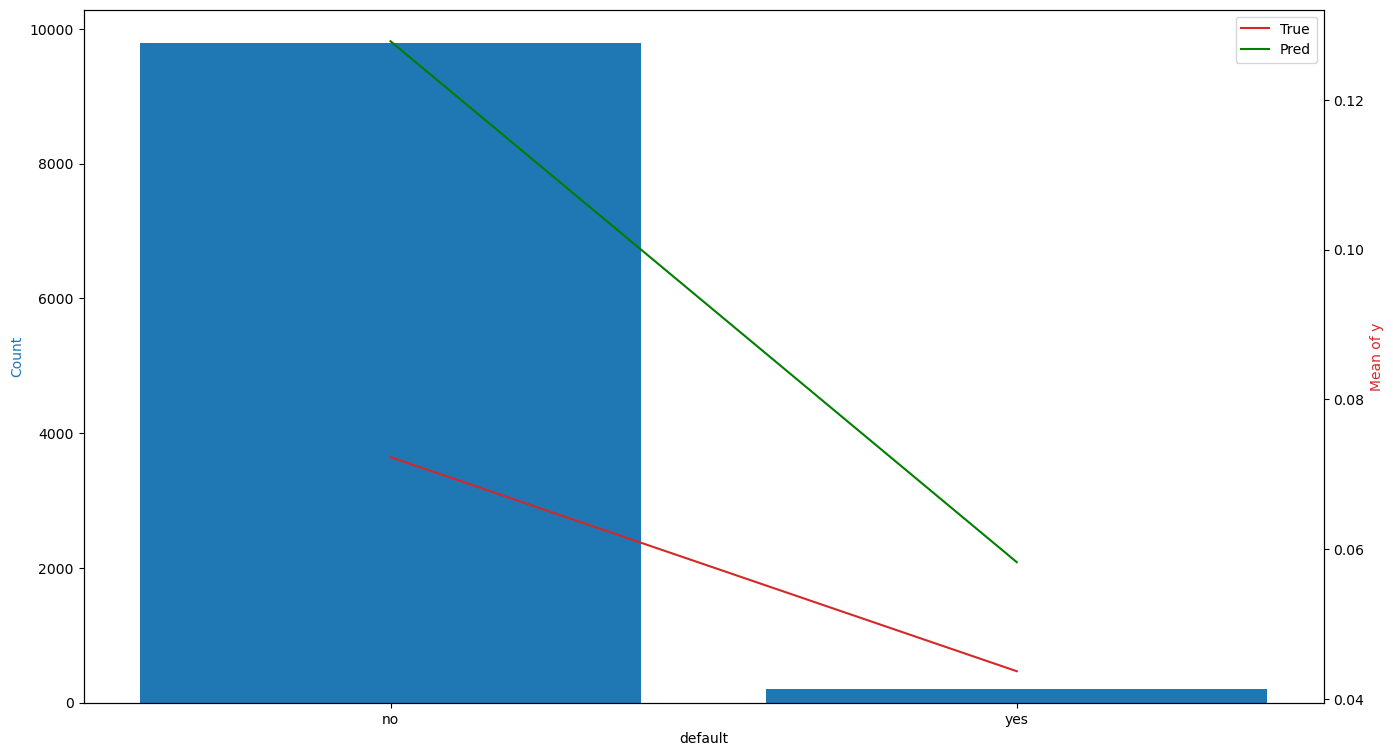

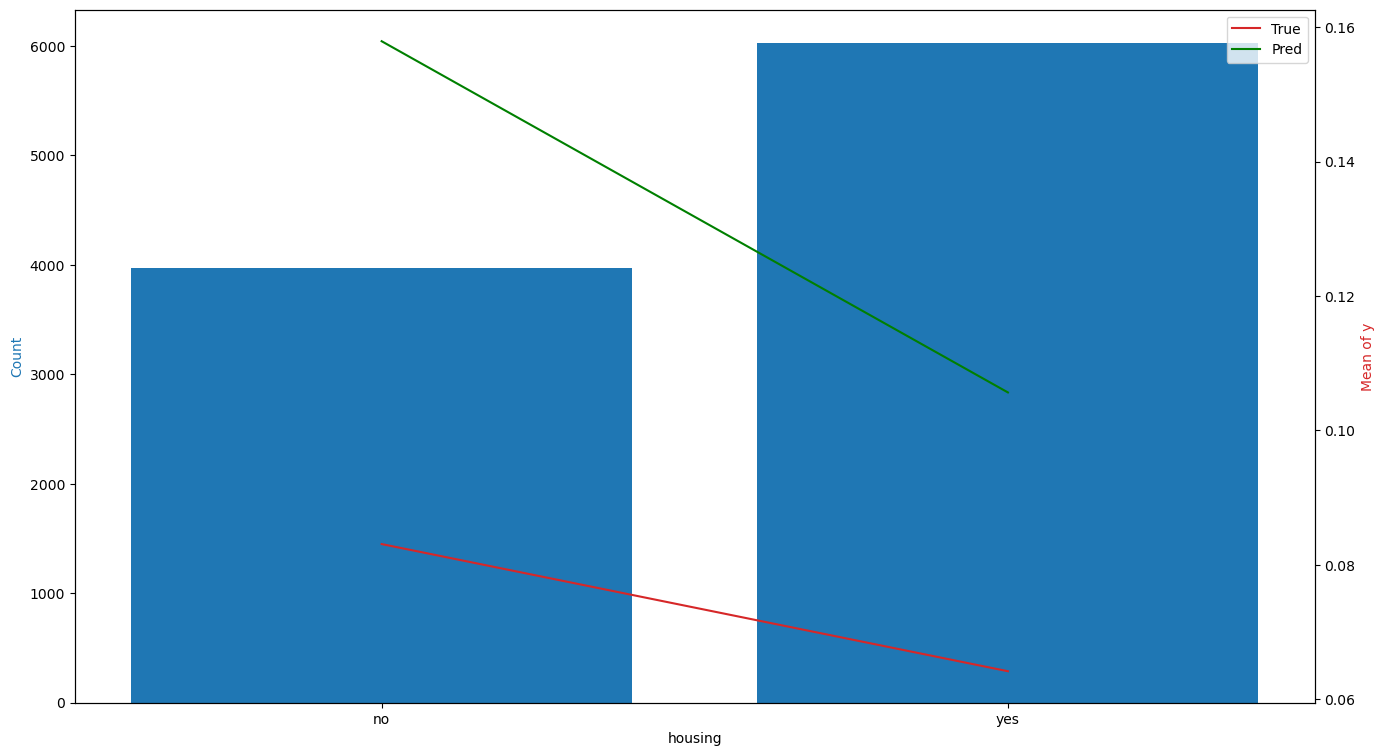

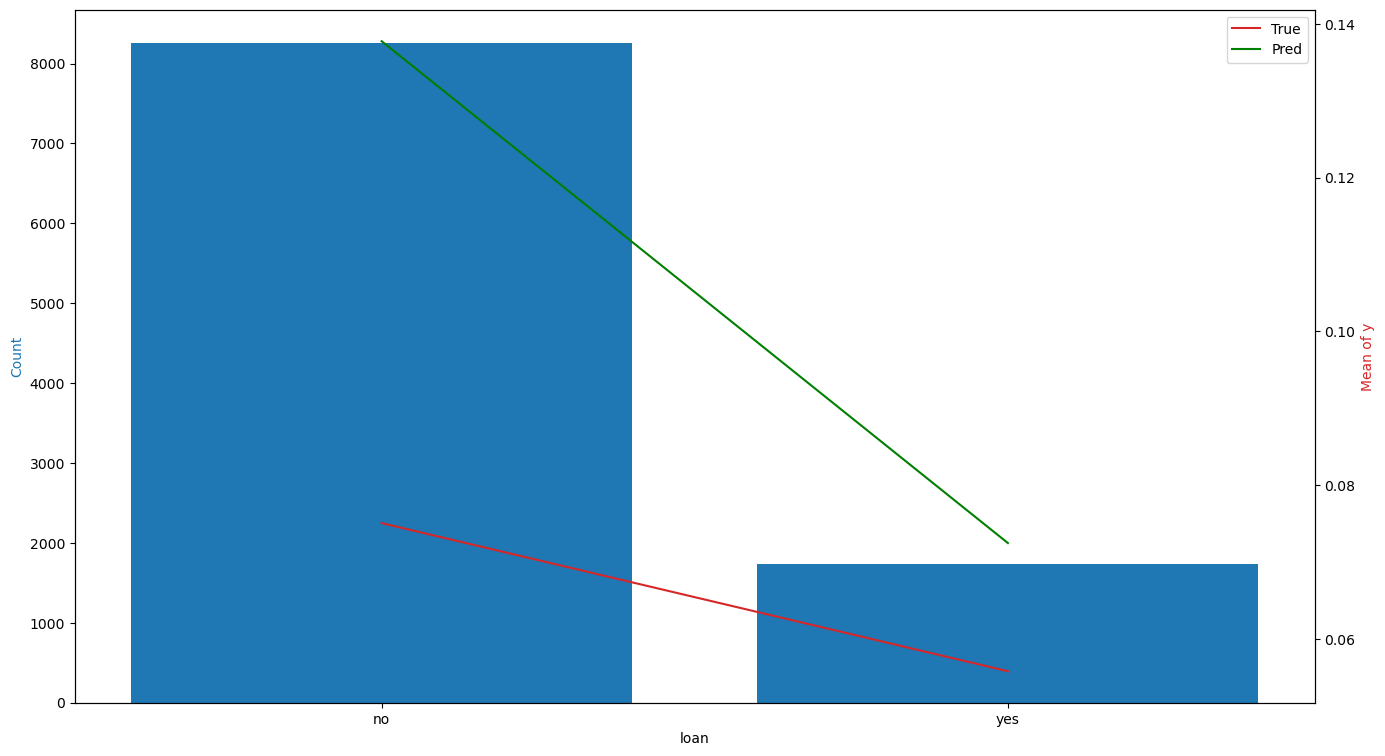

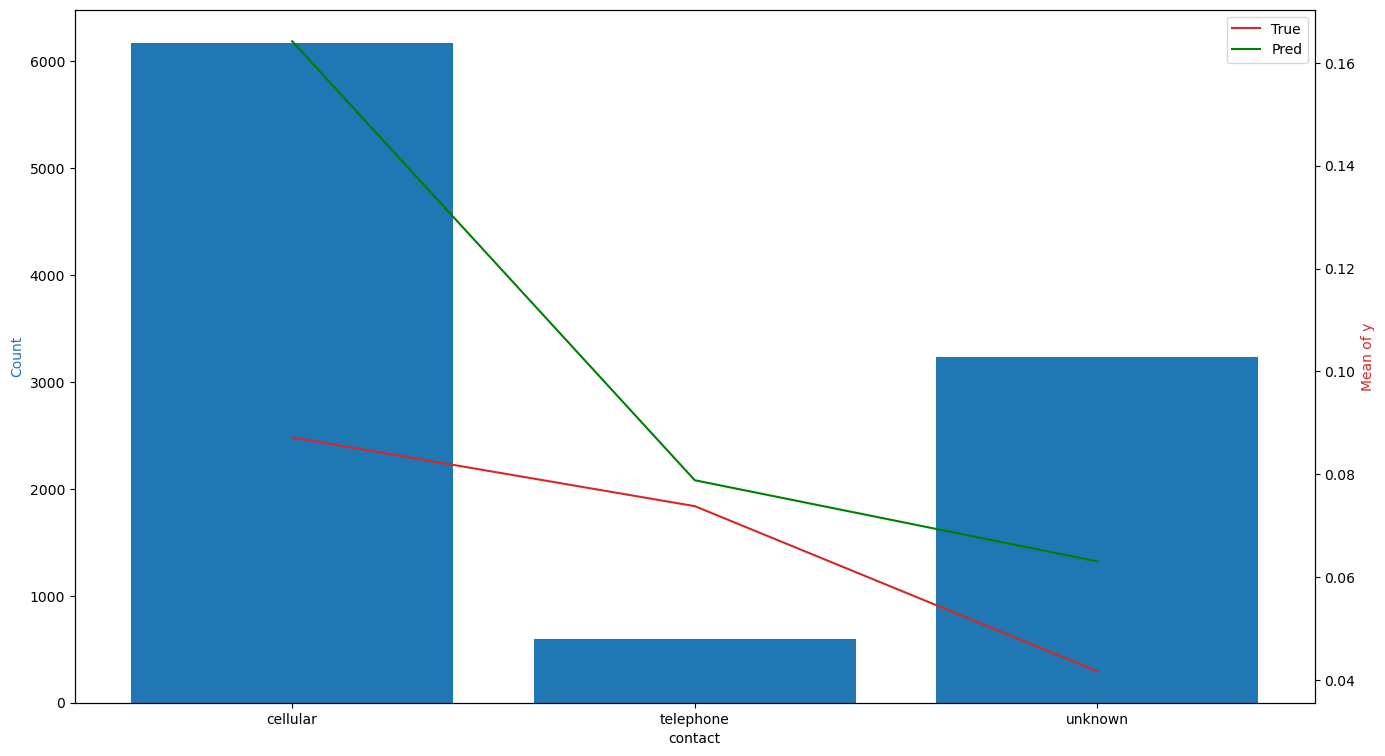

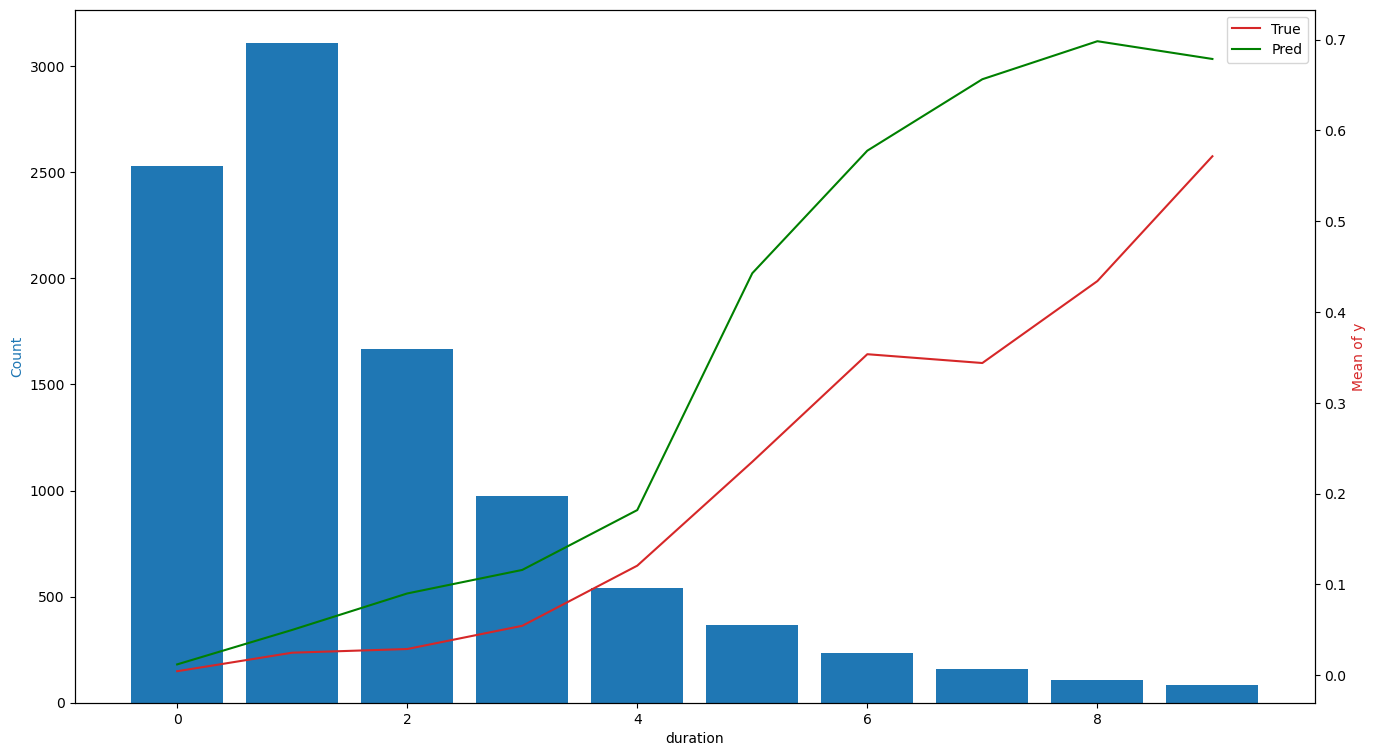

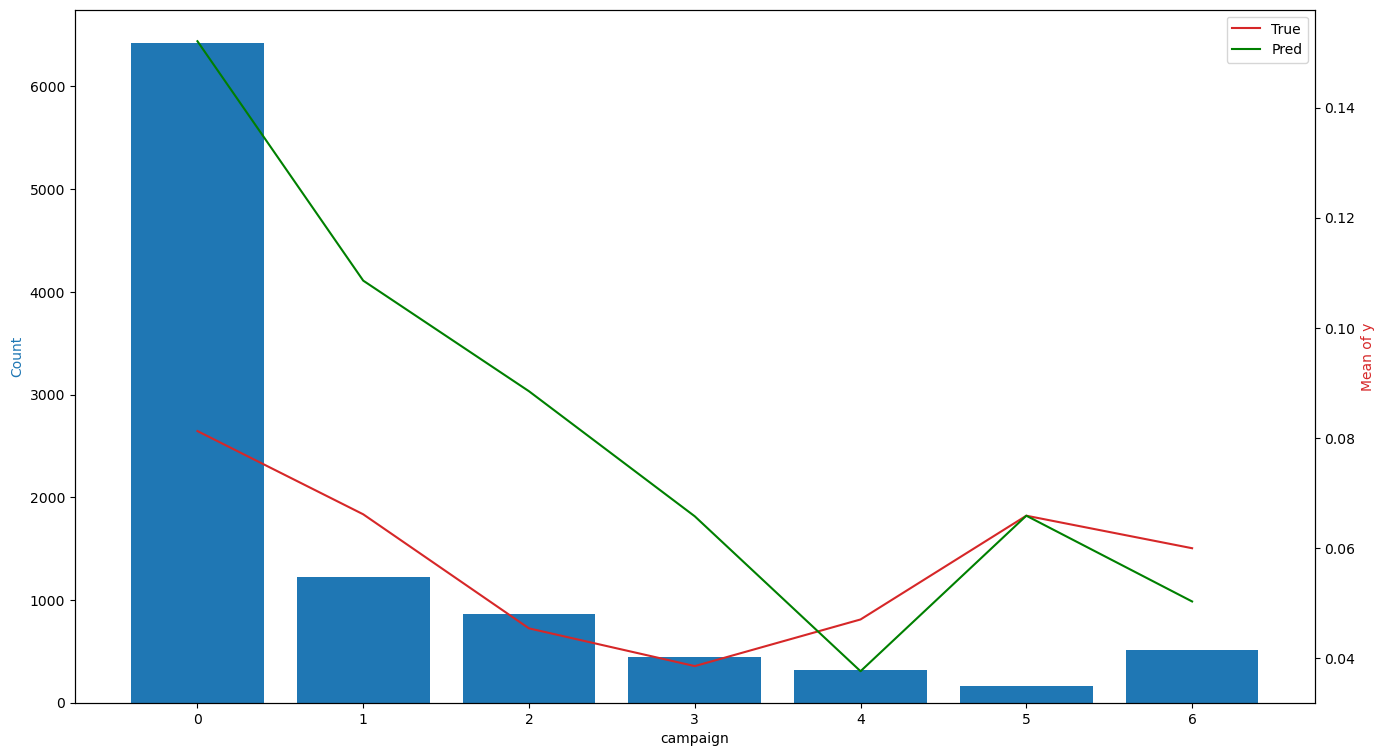

In [48]:
for col in X.columns:
    fig, ax = plt.subplots(figsize=(16,9))
    xi_avg = X_test_agg.groupby(col).agg(mean_y_pred=('y_pred', 'mean'), mean_y_true=('y_true', 'mean'), count_x=(col, 'count'))
    color = 'tab:blue'
    ax.set_xlabel(col)
    ax.set_ylabel('Count', color=color)
    ax.bar(xi_avg.index, xi_avg.count_x, color=color)
    ax2 = ax.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Mean of y', color=color)
    ax2.plot(xi_avg.index, xi_avg.mean_y_true, color=color, label="True")
    ax2.plot(xi_avg.index, xi_avg.mean_y_pred, color="green", label="Pred")
    plt.legend()
    plt.show()

In [64]:
for i in sorted(zip(ohe.get_feature_names_out(), model.feature_importances_), key=lambda x : x[1], reverse=True):
    print(i)

('duration_0.0', 0.23916341)
('duration_1.0', 0.15058145)
('duration_2.0', 0.083646044)
('duration_3.0', 0.057976943)
('contact_unknown', 0.047499582)
('duration_4.0', 0.027179202)
('duration_nan', 0.018481977)
('age_0.0', 0.01579207)
('duration_5.0', 0.01440769)
('housing_yes', 0.013501171)
('age_18.0', 0.012954268)
('loan_yes', 0.010822499)
('campaign_0.0', 0.009533879)
('education_tertiary', 0.009403819)
('job_student', 0.009109516)
('age_2.0', 0.008823069)
('duration_9.0', 0.0087028695)
('age_6.0', 0.008021692)
('job_admin', 0.007954478)
('job_management', 0.0075348495)
('duration_8.0', 0.0073103043)
('job_services', 0.0070585245)
('job_technician', 0.006936173)
('marital_married', 0.006772179)
('job_entrepreneur', 0.0066904677)
('age_12.0', 0.0066120187)
('marital_single', 0.0064919177)
('contact_telephone', 0.00648185)
('age_1.0', 0.006446422)
('campaign_1.0', 0.006438225)
('duration_7.0', 0.0063693877)
('education_primary', 0.006320318)
('age_13.0', 0.006091414)
('age_9.0', 0.00

In [50]:
# explainer = shap.Explainer(model)
# shap_values = explainer(X_t)

In [51]:
# shap.plots.waterfall(shap_values[0])

In [52]:
# Reduce number of bins and keep numerical
# Use different eval metric
# Random search for optimisation
# Prevent overfitting

In [61]:
np.logical_and(y_test == 1, y_pred == 1).sum() / (y_test == 1).sum()

0.5439330543933054

In [65]:
transformer = ColumnTransformer(
    [
        ('cat_cols', ohe, cat_cols),
    ],
    remainder="passthrough"
)

In [66]:
transformer.fit_transform(X, y)

invalid value encountered in cast


<40000x28 sparse matrix of type '<class 'numpy.float64'>'
	with 274853 stored elements in Compressed Sparse Row format>

In [67]:
transformer.get_feature_names_out()

array(['cat_cols__job_admin', 'cat_cols__job_blue-collar',
       'cat_cols__job_entrepreneur', 'cat_cols__job_housemaid',
       'cat_cols__job_management', 'cat_cols__job_retired',
       'cat_cols__job_self-employed', 'cat_cols__job_services',
       'cat_cols__job_student', 'cat_cols__job_technician',
       'cat_cols__job_unemployed', 'cat_cols__job_unknown',
       'cat_cols__marital_divorced', 'cat_cols__marital_married',
       'cat_cols__marital_single', 'cat_cols__education_primary',
       'cat_cols__education_secondary', 'cat_cols__education_tertiary',
       'cat_cols__education_unknown', 'cat_cols__default_yes',
       'cat_cols__housing_yes', 'cat_cols__loan_yes',
       'cat_cols__contact_cellular', 'cat_cols__contact_telephone',
       'cat_cols__contact_unknown', 'remainder__age',
       'remainder__duration', 'remainder__campaign'], dtype=object)

In [73]:
job_group1 = {"blue-collar", "entrepreneur", "services"}
job_group2 = {"unknown", "management", "self-employed", "technician"}
job_group3 = {"retired", "unemployed", "admin"}
job_group4 = {"housemaid"}
job_group3 = {"student"}
X["job"] = X["job"].apply(lambda x : 0 if x in job_group1 else 1 if x in job_group2 else 2 if x in job_group3 else 3 if x in job_group4 else 4)

In [74]:
X["job"]

0        1
1        1
2        0
3        0
4        1
        ..
39995    1
39996    1
39997    4
39998    1
39999    1
Name: job, Length: 40000, dtype: int64

In [101]:
def transform(X, y):
    # Keep some num cols, bin others, group some cat and join
    ohe = OneHotEncoder(drop="if_binary", sparse_output=False)
    job_group1 = {"blue-collar", "entrepreneur", "services"}
    job_group2 = {"unknown", "management", "self-employed", "technician"}
    job_group3 = {"retired", "unemployed", "admin"}
    job_group4 = {"housemaid"}
    job_group3 = {"student"}
    X["job"] = X["job"].apply(lambda x : 0 if x in job_group1 else 1 if x in job_group2 else 2 if x in job_group3 else 3 if x in job_group4 else 4)
    X_cat = X[["job", "marital", "education", "default", "housing", "loan", "contact"]]
    X_num = X[["age", "duration",  "campaign"]]
    X_cat = ohe.fit_transform(X_cat, y)
    labels = ohe.get_feature_names_out()
    X_cat = pd.DataFrame(X_cat, columns = labels)
    X_t = pd.concat([X_num, X_cat], axis=1)
    return X_t, ohe
def inv_transform(X_t, ohe):
    X_cat = X_t[ohe.get_feature_names_out()]
    X_cat = ohe.inverse_transform(X_cat)
    X_cat = pd.DataFrame(X_cat, columns=ohe.feature_names_in_)
    X_num = X_t[["age", "duration",  "campaign"]]
    X = pd.concat([X_num, X_cat], axis=1)
    return X

In [102]:
temp, ohe = transform(X,y)
inv_transform(temp, ohe)

,age,duration,campaign,job,marital,education,default,housing,loan,contact
0,58,261,1,4,married,tertiary,no,yes,no,unknown
1,44,151,1,4,single,secondary,no,yes,no,unknown
2,33,76,1,4,married,secondary,no,yes,yes,unknown
3,47,92,1,4,married,unknown,no,yes,no,unknown
4,33,198,1,4,single,unknown,no,no,no,unknown
...,...,...,...,...,...,...,...,...,...,...
39995,53,107,1,4,married,tertiary,no,no,no,cellular
39996,30,238,3,4,single,tertiary,no,no,no,cellular
39997,54,170,1,4,divorced,secondary,no,no,no,cellular
39998,34,342,1,4,married,tertiary,no,no,no,cellular


In [88]:
X["job"].apply(lambda x : 0 if x in job_group1 else 1 if x in job_group2 else 2 if x in job_group3 else 3 if x in job_group4 else 4)

0        1
1        1
2        0
3        0
4        1
        ..
39995    1
39996    1
39997    4
39998    1
39999    1
Name: job, Length: 40000, dtype: int64

In [98]:
ohe.feature_names_in_

array(['job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact'], dtype=object)